<a href="https://colab.research.google.com/github/maudl3116/Distribution_Regression_Streams/blob/master/notebooks/Synthetic_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Testing-pipeline" data-toc-modified-id="Testing-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Testing pipeline</a></span></li><li><span><a href="#Comparison-Sig-Kernel-and-RBF-Kernel" data-toc-modified-id="Comparison-Sig-Kernel-and-RBF-Kernel-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison Sig-Kernel and RBF-Kernel</a></span></li></ul></div>

In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     
PROJ = 'My Drive/Distribution_Regression_Proj'       

drive.mount(ROOT)    

PROJECT_PATH = join(ROOT, PROJ)

GIT_PATH = "https://d1f5fb17f9201eeb70248ecea10d65a859c2fffe@github.com/maudl3116/Distribution_Regression_Streams.git"

!git clone "{GIT_PATH}"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Cloning into 'Distribution_Regression_Streams'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 770 (delta 164), reused 206 (delta 113), pack-reused 509
Receiving objects: 100% (770/770), 18.80 MiB | 6.69 MiB/s, done.
Resolving deltas: 100% (508/508), done.


In [0]:
# no need to run again if notebook not closed
!pip install iisignature
#!pip install gpytorch
#!pip install fbm
#!pip install -q torch==1.3.1 
#!pip install signatory==1.1.6.1.3.1

In [0]:
%pwd
#!git config --global user.email "maud.lemercier@spc.ox.ac.uk"
#!git config --global user.name "maudl3116"
%cd Distribution_Regression_Streams
!git pull 

In [5]:
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import numpy as np
import data_generators.circuit
from data_generators import circuit
import utils
from utils import *
import GP_models as GP_models
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features
from signature_features import *
import experiment_script
from experiment_script import exp1
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


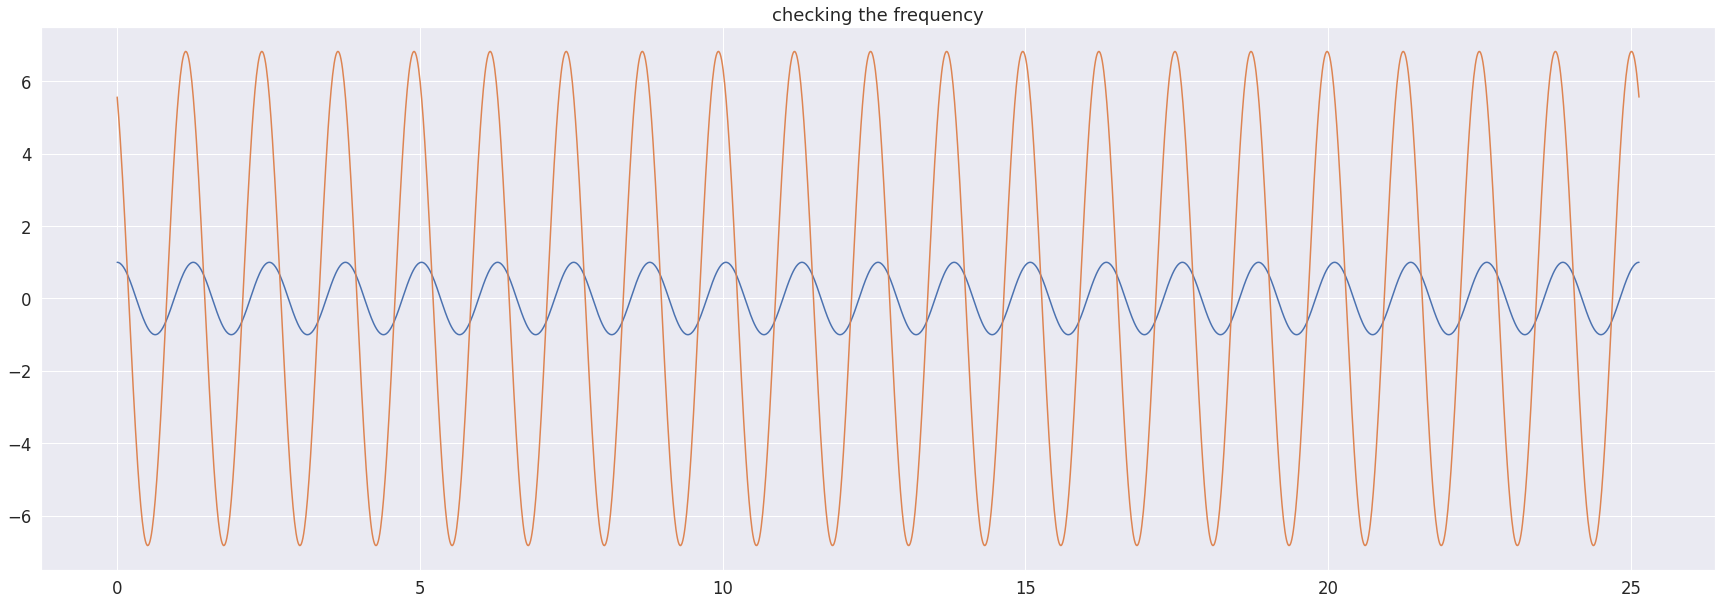

In [214]:
reload(circuit)
N_bags = 100
N_items=30
omega = 5.
nb_periods = 20
example = circuit.Circuit(N_bags=N_bags, N_items=N_items,spec_param={'phi':[np.pi/8,np.pi/2],'em':[1,1],'R':[0.1,0.6],'L':[0.1,0.5],'C':[1,3],'omega':[omega,omega]},t_span=np.linspace(0,nb_periods*2*np.pi/omega,nb_periods*100),nb_obs=nb_periods*2)
#example.generate_data_RLC()
example.generate_data()
#example.get_e_ang()

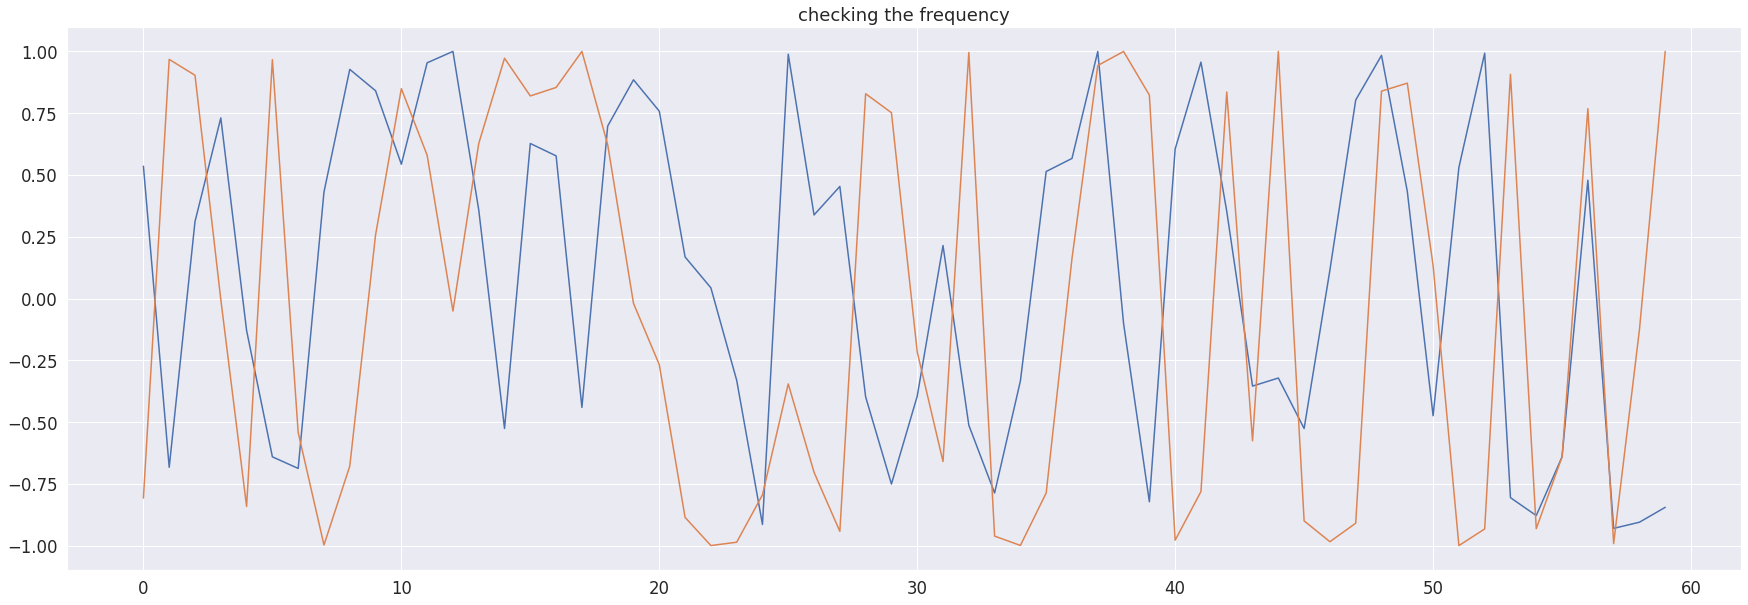

In [162]:
figure = plt.figure(figsize=(30, 10))
plt.plot(example.paths[0, 0,:, 0])
plt.plot(example.paths[0, 1,:, 0])
plt.title('checking the frequency')
plt.show()

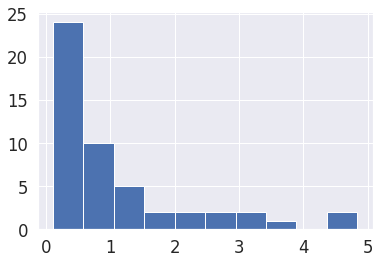

[1.51561288]
[0.83286062]


In [60]:
phi = np.arctan(example.tan_phi)[:,None]
example.labels = example.P[:,None]
plt.hist(example.labels)
plt.show()
print(max(phi))
print(min(phi))
plt.show()

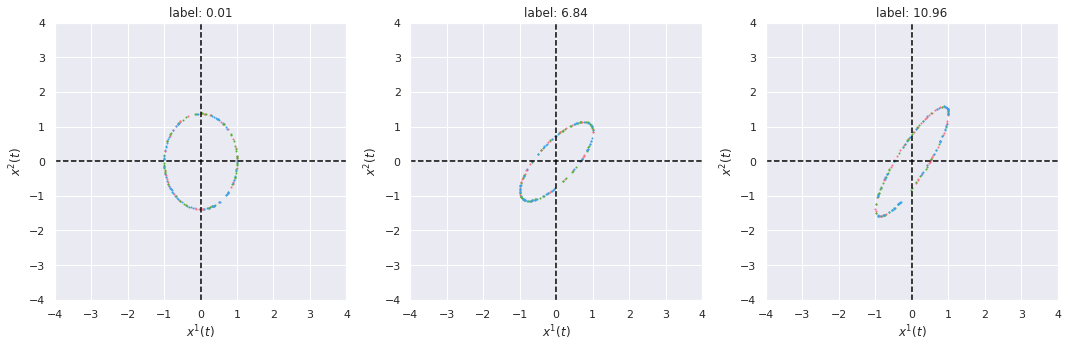

In [172]:
example.plot(N_items=3)

In [0]:
reload(utils)
example.labels = example.phi[:,None]#
#example.labels = example.P[:,None]#np.arctan(example.tan_phi)[:,None]#example.P[:,None]
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(example.labels,example.paths,standardized=True,method='stratify')

In [221]:
print(example.labels.shape)

(100, 1)


In [0]:
X_aug = data_scaled

shape of the final features (N_bags, D): (100, 126)


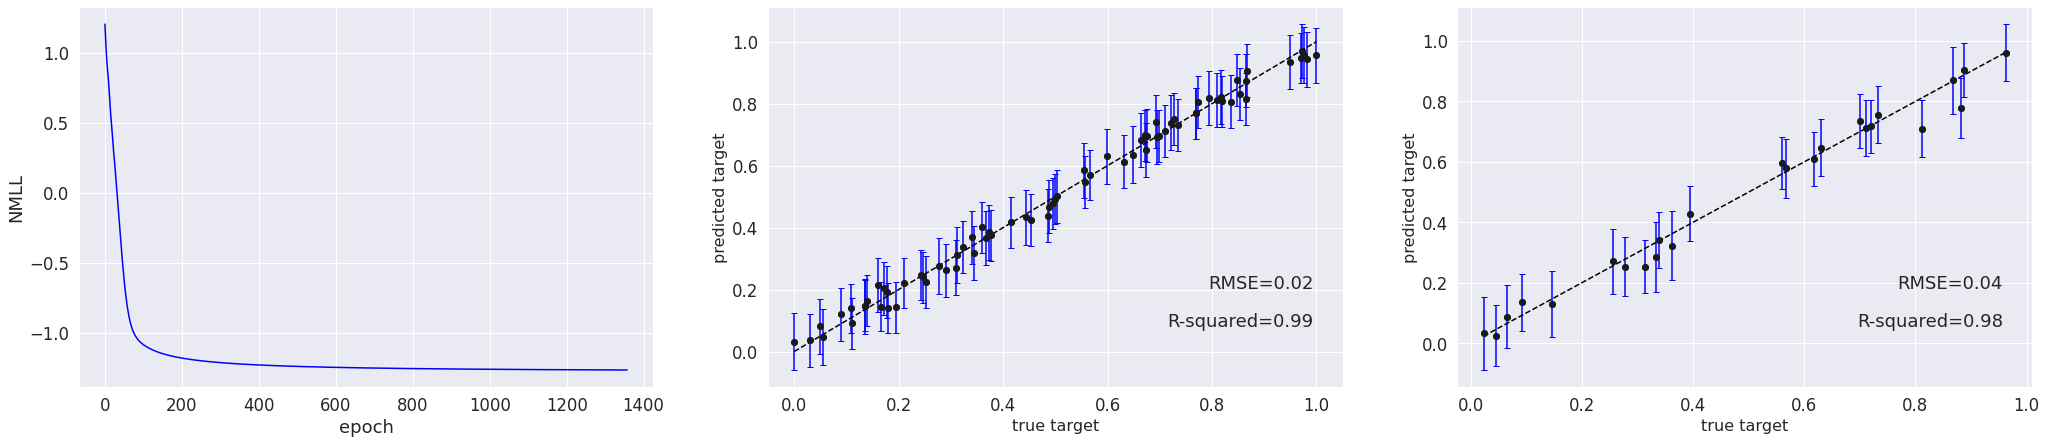

In [223]:
reload(experiments)
reload(signature_features)
reload(GP_sig)
reload(GP_sig_ARD)

sig_level = 6

# Compute the expected signature
#expected_sig = signature_features.scaled_expected_sig([e.copy() for e in X_aug],sig_level)
expected_sig = signature_features.scaled_expected_sig([e.copy() for e in data_scaled], sig_level, M=1000,
                                                                      a=1, ilya_rescale=True, return_norms=False)
# Standard scale the features
features = expected_sig
# var = np.var(features,axis=0)
# ## potentially scale the features
# scaler = StandardScaler()
# to_fit = [features[i] for i in train_indices]
# scaler.fit(to_fit)
# features = scaler.transform(features)

print('shape of the final features (N_bags, D):', features.shape)

# Precompute the Gram matrix, as we do not optimize any parameter
K_precomputed = experiments.precompute_K(features)

# Train and Predict
a,b,c,d = experiments.experiment_precomputed(K_precomputed,y_scaled,train_indices,test_indices,param_init=[0,0,0],RBF=True,plot=True)
     
#a,b,c,d = experiments.experiment_ARD(features,y_scaled,2,sig_level,train_indices,test_indices,param_init=[10,0,0],RBF=True,plot=True)
      

shape of the input (N_bags, N_items, D): (100, 30, 80)


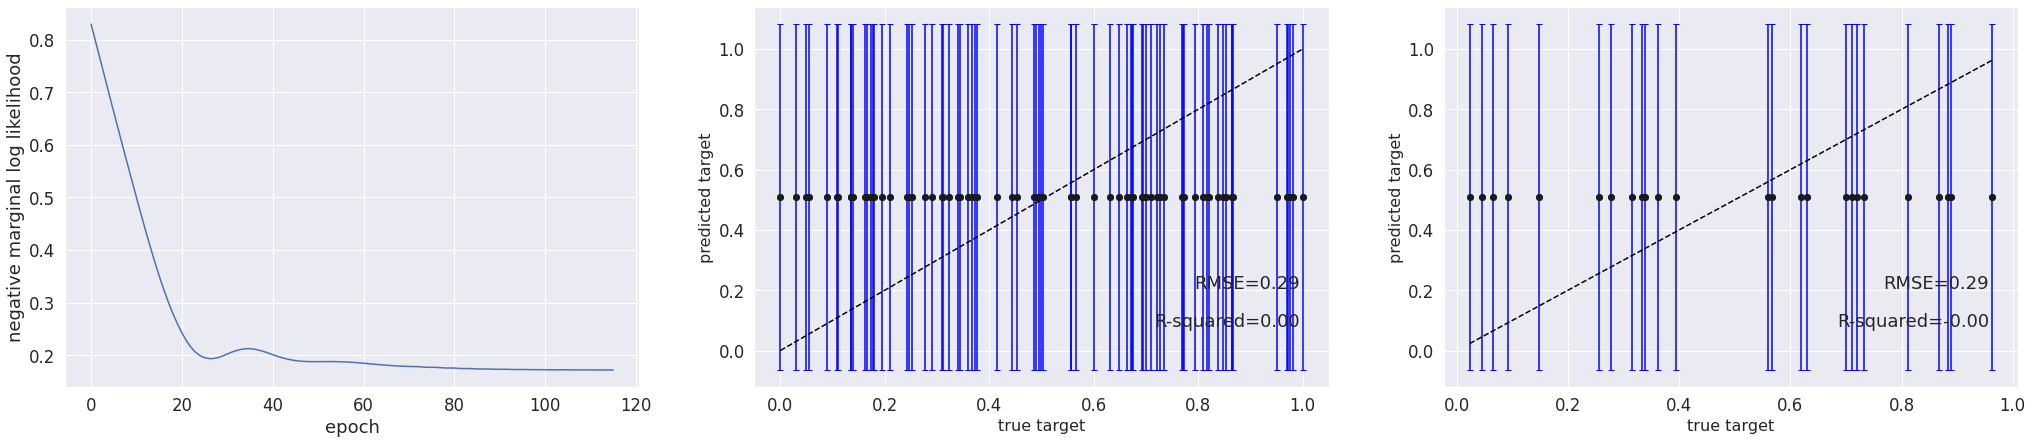

In [224]:
reload(experiments)
reload(GP_naive)
input_ = data_scaled
N = np.array(input_).shape[3]
input_ = np.concatenate([np.array(np.array(input_)[:,:,:,k]) for k in range(N)],axis=2)
print('shape of the input (N_bags, N_items, D):', input_.shape)

train_RBF_rmse, train_RBF_r2, test_RBF_rmse, test_RBF_r2 = experiments.naive_experiment(input_, y_scaled, train_indices, test_indices,
                                                   RBF_top=False,param_init=[15,0,0,0],device=torch.device('cuda'),plot=True)

    